In [1]:
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import math
import random
import pickle
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, validation_curve, GridSearchCV
from scipy import stats,spatial

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import TransformedTargetRegressor

from sklearn.linear_model import ElasticNet

In [2]:
data = pd.read_csv('C:\\Users\\dtulomba\\Documents\\ProjetsCours\\projet4\\2016_Building_Energy_Benchmarking_cleaned.csv', sep=',')

In [3]:
data.columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'BuildingAge', 'distance_center', 'nb_use_types',
       'Electricity', 'SteamUse', 'NaturalGas', 'Buildings Consumption',
       'Neighborhood Consumption'],
      dtype='object')

In [4]:
data.dropna()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingAge,distance_center,nb_use_types,Electricity,SteamUse,NaturalGas,Buildings Consumption,Neighborhood Consumption
0,1.0,12,88434,0,60.0,7.226362e+06,249.98,96,1.419403,1,True,True,True,medium electricity consuming buildings,Neighborhood with high electricity consumption
1,1.0,11,103566,15064,61.0,8.387933e+06,295.86,27,1.829354,3,True,False,True,medium electricity consuming buildings,Neighborhood with high electricity consumption
2,1.0,10,61320,0,56.0,6.794584e+06,286.43,97,1.523923,1,True,True,True,medium electricity consuming buildings,Neighborhood with high electricity consumption
4,1.0,11,83008,0,27.0,5.758795e+06,176.14,97,1.937460,1,True,False,True,medium electricity consuming buildings,Neighborhood with high electricity consumption
7,1.0,2,56228,0,95.0,1.539478e+06,38.53,62,10.089198,1,True,False,True,very low electricity consumption buildings,Neighborhood with avery low electricity consum...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405,1.0,2,24990,0,9.0,4.420650e+06,134.80,94,7.729973,1,True,False,True,very low electricity consumption buildings,Neighborhood with avery low electricity consum...
1407,1.0,3,45000,0,77.0,1.325973e+06,9.24,8,5.198037,2,True,False,False,very low electricity consumption buildings,Neighborhood with avery low electricity consum...
1415,1.0,1,13661,0,75.0,5.026677e+05,3.50,71,2.957733,1,True,False,False,very low electricity consumption buildings,Neighborhood with avery low electricity consum...
1418,1.0,1,15398,0,93.0,3.878100e+05,7.79,63,8.656251,1,True,False,True,very low electricity consumption buildings,Neighborhood with avery low electricity consum...


### Pipeline

Définition du Pipeline incluant le pré-traitement

Nous procédons à une validation croisée pour sélectionner les hyperparamètres et le modèle.

Pour que le prétraitement soit réalisé sans fuite de données, nous utiliserons un « pipeline ».
Définition du prétraitement différencié selon les colonnes

Nous appliquerons un pré-traitement différencié selon que les caractéristiques sont quantitatives ou catégorielles. Dans cette partie, nous définissons ce pré-traitement dans un pipe-line pour usage ultérieur, intégré à la validation croisée.

    - imputation
    - target encoding
    - standardisation



In [5]:
data_pipeline = data.copy()

In [6]:
data.columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'BuildingAge', 'distance_center', 'nb_use_types',
       'Electricity', 'SteamUse', 'NaturalGas', 'Buildings Consumption',
       'Neighborhood Consumption'],
      dtype='object')

### Initialisation de la pipeline 

In [7]:

#data = pd.read_csv('data.csv')
X = data_pipeline.drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'ENERGYSTARScore'], axis=1)
y = data_pipeline['SiteEnergyUse(kBtu)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the numeric features and categorical features
numeric_features = ['NumberofBuildings','NumberofFloors', 'PropertyGFAParking', 'PropertyGFATotal', 'BuildingAge',
                    'distance_center', 'nb_use_types', 'Electricity', 'SteamUse','NaturalGas']
categorical_features = ['Buildings Consumption', 'Neighborhood Consumption']


### Modèle avec 'SiteEnergyUse(kBtu)'

In [8]:

def regression_pipeline(X_train, X_test, y_train, y_test, regressor, param_grid):

    # Define the transformers
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    # Combine the transformers into a preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Define the pipeline steps
    steps = [
        ('preprocessor', preprocessor),
        ('transformer', TransformedTargetRegressor(regressor=regressor, func=np.log1p, inverse_func=np.expm1))
    ]
    # Create the pipeline
    pipeline = Pipeline(steps)

    # Define hyperparameters to tune
    param_grid = param_grid

    # Define the list of scoring functions
    scoring = {
        'mse': make_scorer(mean_squared_error, greater_is_better=False),
        'r2': make_scorer(r2_score)
    }

    # Create the grid search object
    grid_search_ = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, refit='mse')

    # Fit the pipeline to the training data
    grid_search_.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search_.best_estimator_

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Calculate mean squared error and R-squared
    mse_ = mean_squared_error(y_test, y_pred)
    r2_ = r2_score(y_test, y_pred)
    
    best_params=grid_search_.best_params_
    data_cv_results = pd.DataFrame(grid_search_.cv_results_)
    cv_r2 = data_cv_results.loc[data_cv_results["params"]==best_params]["mean_test_r2"].values[0]
    cv_mse = data_cv_results.loc[data_cv_results["params"]==best_params]["mean_test_mse"].values[0]*-1
    cv_meanfittime = data_cv_results.loc[data_cv_results["params"]==best_params]["mean_fit_time"].values[0]
    
    # Print the results
    print('test mse:', mse_)
    print('test r2:', r2_)
    print('cv mse:', cv_mse)
    print('cv r2:', cv_r2)
    
    return best_params, best_model, [cv_r2, cv_mse, cv_meanfittime, mse_, r2_]


## RANDOM FOREST 

In [9]:
regressor = RandomForestRegressor()

# Define hyperparameters to tune
param_grid_rf = {
    'transformer__regressor__n_estimators': [50, 100, 150],
    'transformer__regressor__max_depth': [3, 4, 5, None],
    'transformer__regressor__min_samples_split': [2, 5, 10],
    'transformer__regressor__min_samples_leaf': [1, 2, 4],
    'transformer__regressor__max_features': ['sqrt', 'log2']
}

rf_model = regression_pipeline(X_train, X_test, y_train, y_test, regressor, param_grid_rf)

test mse: 6373505818160.866
test r2: 0.37312826123139287
cv mse: 5161406634872.039
cv r2: 0.4255422796880183


In [10]:
rf_model[2][2]

0.2879281997680664

## ELASTICNET

In [11]:
regressor = ElasticNet()

# Define hyperparameters to tune
param_grid_el = {
    'transformer__regressor__max_iter': [1000],
    'transformer__regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'transformer__regressor__l1_ratio': np.arange(0.0, 1.0, 0.1),
}

el_model = regression_pipeline(X_train, X_test, y_train, y_test, regressor, param_grid_el)

C:\Users\dtulomba\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.708e+02, tolerance: 3.209e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dtulomba\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.736e+02, tolerance: 3.427e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

C:\Users\dtulomba\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.098e+00, tolerance: 3.415e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\dtulomba\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.231e+00, tolerance: 3.206e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\dtulomba\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

C:\Users\dtulomba\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.174e+03, tolerance: 3.209e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dtulomba\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.286e+03, tolerance: 3.427e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

test mse: 1.420306382379562e+16
test r2: -1395.9547638435276
cv mse: 7369979670531.597
cv r2: 0.19039768822613115


In [12]:
el_model[2][2]

0.007169866561889648

# KNN MODELE

In [13]:
data_pipeline.columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'BuildingAge', 'distance_center', 'nb_use_types',
       'Electricity', 'SteamUse', 'NaturalGas', 'Buildings Consumption',
       'Neighborhood Consumption'],
      dtype='object')

In [14]:
regressor = KNeighborsRegressor()

# Define hyperparameters to tune
param_grid_knn = {
    'transformer__regressor__n_neighbors': list(range(1, 31)),
}

knn_model = regression_pipeline(X_train, X_test, y_train, y_test, regressor, param_grid_knn)

test mse: 7145450329093.027
test r2: 0.2972029837456397
cv mse: 5961950796632.604
cv r2: 0.3371214152957778


In [15]:
knn_model[2][2]

0.008800077438354491

## GRADIENT BOOSTING

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

In [17]:
regressor = GradientBoostingRegressor()

# Define hyperparameters to tune
param_grid_grb = {
    'transformer__regressor__n_estimators': [50, 100, 150],
    'transformer__regressor__learning_rate': [0.1, 0.01, 0.001],
    'transformer__regressor__max_depth': [3, 4, 5],
    'transformer__regressor__min_samples_split': [2, 5, 10],
    'transformer__regressor__min_samples_leaf': [1, 2, 4],
    'transformer__regressor__max_features': ['sqrt', 'log2']
}

grb_model = regression_pipeline(X_train, X_test, y_train, y_test, regressor, param_grid_grb)

test mse: 6476329569538.901
test r2: 0.36301494123890243
cv mse: 4885227245459.064
cv r2: 0.45523872167225726


In [18]:
grb_model[2][2]

0.06172566413879395

## XGBOOST

In [19]:
import xgboost as xgb

In [20]:
regressor = xgb.XGBRegressor(objective='reg:squarederror')

# Define hyperparameters to tune
param_grid_xgb = {
    'transformer__regressor__n_estimators': [50, 100, 150],
    'transformer__regressor__learning_rate': [0.1, 0.01, 0.001],
    'transformer__regressor__max_depth': [3, 4, 5],
    'transformer__regressor__min_samples_split': [2, 5, 10],
    'transformer__regressor__min_samples_leaf': [1, 2, 4],
    'transformer__regressor__max_features': ['sqrt', 'log2']
}

xgb_model = regression_pipeline(X_train, X_test, y_train, y_test, regressor, param_grid_xgb)

[16:18:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:06] WARNING: C:/build

[16:18:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:09] WARNING: C:/build

[16:18:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:12] WARNING: C:/build

[16:18:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:15] WARNING: C:/build

[16:18:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:18] WARNING: C:/build

[16:18:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:21] WARNING: C:/build

[16:18:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:24] WARNING: C:/build

[16:18:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:26] WARNING: C:/build

[16:18:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:29] WARNING: C:/build

[16:18:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:33] WARNING: C:/build

[16:18:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:36] WARNING: C:/build

[16:18:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:39] WARNING: C:/build

[16:18:42] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:43] WARNING: C:/build

[16:18:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:46] WARNING: C:/build

[16:18:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:49] WARNING: C:/build

[16:18:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:53] WARNING: C:/build

[16:18:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:18:56] WARNING: C:/build

[16:19:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:00] WARNING: C:/build

[16:19:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:04] WARNING: C:/build

[16:19:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:07] WARNING: C:/build

[16:19:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:12] WARNING: C:/build

[16:19:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:16] WARNING: C:/build

[16:19:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:20] WARNING: C:/build

[16:19:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:23] WARNING: C:/build

[16:19:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:26] WARNING: C:/build

[16:19:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:29] WARNING: C:/build

[16:19:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:32] WARNING: C:/build

[16:19:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:34] WARNING: C:/build

[16:19:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:37] WARNING: C:/build

[16:19:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:40] WARNING: C:/build

[16:19:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:43] WARNING: C:/build

[16:19:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:46] WARNING: C:/build

[16:19:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:49] WARNING: C:/build

[16:19:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:52] WARNING: C:/build

[16:19:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:55] WARNING: C:/build

[16:19:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:19:58] WARNING: C:/build

[16:20:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:01] WARNING: C:/build

[16:20:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:04] WARNING: C:/build

[16:20:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:07] WARNING: C:/build

[16:20:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:10] WARNING: C:/build

[16:20:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:13] WARNING: C:/build

[16:20:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:17] WARNING: C:/build

[16:20:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:20] WARNING: C:/build

[16:20:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:23] WARNING: C:/build

[16:20:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:26] WARNING: C:/build

[16:20:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:29] WARNING: C:/build

[16:20:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:32] WARNING: C:/build

[16:20:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:35] WARNING: C:/build

[16:20:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:38] WARNING: C:/build

[16:20:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:41] WARNING: C:/build

[16:20:44] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:44] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:44] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:44] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:44] WARNING: C:/build

[16:20:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:47] WARNING: C:/build

[16:20:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:50] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:50] WARNING: C:/build

[16:20:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:53] WARNING: C:/build

[16:20:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:56] WARNING: C:/build

[16:20:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:20:59] WARNING: C:/build

[16:21:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:02] WARNING: C:/build

[16:21:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:05] WARNING: C:/build

[16:21:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:08] WARNING: C:/build

[16:21:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:11] WARNING: C:/build

[16:21:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:14] WARNING: C:/build

[16:21:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:17] WARNING: C:/build

[16:21:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:20] WARNING: C:/build

[16:21:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:23] WARNING: C:/build

[16:21:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:26] WARNING: C:/build

[16:21:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:29] WARNING: C:/build

[16:21:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:32] WARNING: C:/build

[16:21:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:35] WARNING: C:/build

[16:21:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:38] WARNING: C:/build

[16:21:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[16:21:41] WARNING: C:/build

In [21]:
list_model = ['Random Forest','Elastic Net','KNN Model','Gradient Boosting','XGBoost']
list_labels = ['cv r2','cv mse', 'mean fit time', 'test mse','test r2']
list_metrics = [rf_model[2], el_model[2], knn_model[2], grb_model[2], xgb_model[2]]

resultats_final = pd.DataFrame(list_metrics, index=list_model, columns=list_labels)

In [22]:
resultats_final

,cv r2,cv mse,mean fit time,test mse,test r2
Random Forest,0.425542,5.161407e+12,0.287928,6.373506e+12,0.373128
Elastic Net,0.190398,7.369980e+12,0.007170,1.420306e+16,-1395.954764
KNN Model,0.337121,5.961951e+12,0.008800,7.145450e+12,0.297203
Gradient Boosting,0.455239,4.885227e+12,0.061726,6.476330e+12,0.363015
XGBoost,0.440805,4.974630e+12,0.079573,6.157119e+12,0.394411


<AxesSubplot:>

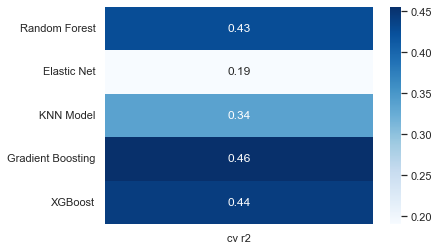

In [23]:
#sns.color_palette("Spectral", as_cmap=True)
sns.heatmap(resultats_final[['cv r2']], annot=True, fmt=".2f", cmap="Blues")

<AxesSubplot:>

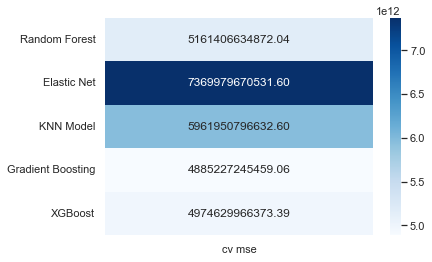

In [24]:
sns.heatmap(resultats_final[[ 'cv mse']], annot=True, fmt=".2f", cmap="Blues")

<AxesSubplot:>

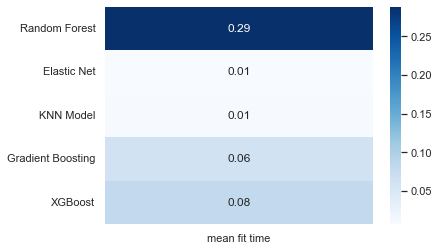

In [25]:
sns.heatmap(resultats_final[['mean fit time']], annot=True, fmt=".2f", cmap="Blues")

In [26]:
from sklearn import set_config
set_config(display="diagram")

# Fitting a Linear Simulation with Gradient Boosting

In [27]:
import numpy as np
import scipy as sp
import xgboost
import shap
import sklearn
from sklearn.model_selection import train_test_split

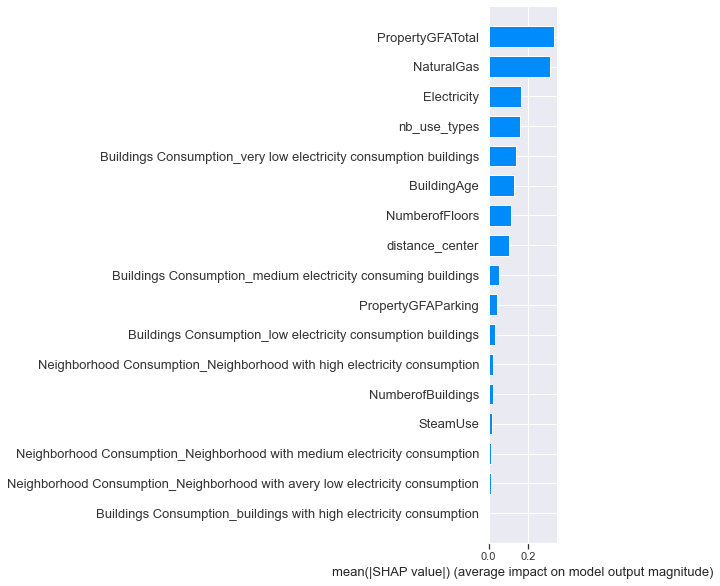

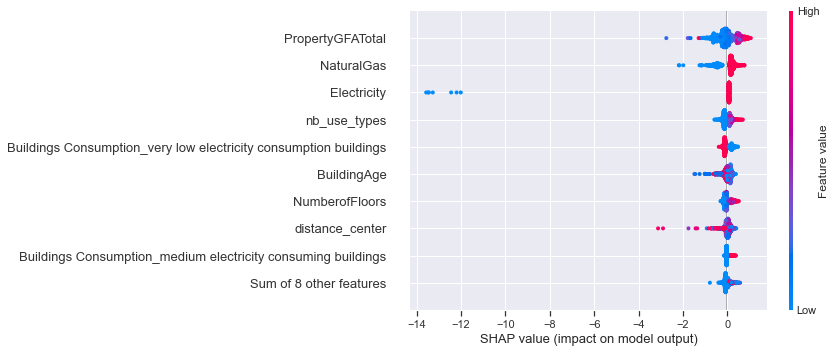

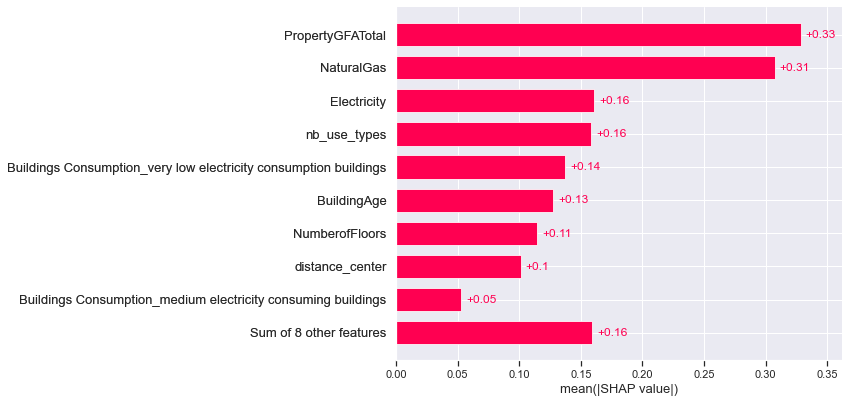

In [29]:
# Define the transformers
numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

#colonne a transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#Calibrage
preprocessor.fit(X_train)

#Transformation
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


# Extraction des noms de variables
num_feature_names = preprocessor.transformers_[0][2]
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = num_feature_names + list(cat_feature_names)

# Calcul des valeurs SHAP pour chaque feature
explainer = shap.Explainer(grb_model[1]['transformer'].regressor_) #XGS
shap_values = explainer(X_train_transformed)

# Création d'un summary plot
shap.summary_plot(shap_values, X_train_transformed, plot_type="bar",feature_names=feature_names)

shap_values.feature_names = feature_names

shap.plots.beeswarm(shap_values)

# Création d'un bar plot
shap.plots.bar(shap_values)

In [30]:
preprocessor.named_transformers_['cat'].named_steps['onehot']

OneHotEncoder(handle_unknown='ignore')

In [31]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['NumberofBuildings', 'NumberofFloors',
                                  'PropertyGFAParking', 'PropertyGFATotal',
                                  'BuildingAge', 'distance_center',
                                  'nb_use_types', 'Electricity', 'SteamUse',
                                  'NaturalGas']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Buildings Consumption',
                                  'Neighborhood Consumption'])])

# Model avec SiteEnergyUse(kbtu)

In [35]:
#data = pd.read_csv('data.csv')
X = data_pipeline.drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], axis=1)
y = data_pipeline['SiteEnergyUse(kBtu)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the numeric features and categorical features
numeric_features = ['NumberofBuildings','NumberofFloors', 'PropertyGFAParking', 'PropertyGFATotal', 'BuildingAge',
                    'distance_center', 'nb_use_types', 'Electricity', 'SteamUse','NaturalGas', 'ENERGYSTARScore']
categorical_features = ['Buildings Consumption', 'Neighborhood Consumption']

In [36]:
def regression_pipeline(X_train, X_test, y_train, y_test, regressor, param_grid):

    # Define the transformers
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    # Combine the transformers into a preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Define the pipeline steps
    steps = [
        ('preprocessor', preprocessor),
        ('transformer', TransformedTargetRegressor(regressor=regressor, func=np.log1p, inverse_func=np.expm1))
    ]
    # Create the pipeline
    pipeline = Pipeline(steps)

    # Define hyperparameters to tune
    param_grid = param_grid

    # Define the list of scoring functions
    scoring = {
        'mse': make_scorer(mean_squared_error, greater_is_better=False),
        'r2': make_scorer(r2_score)
    }

    # Create the grid search object
    grid_search_ = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, refit='mse')

    # Fit the pipeline to the training data
    grid_search_.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search_.best_estimator_

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Calculate mean squared error and R-squared
    mse_ = mean_squared_error(y_test, y_pred)
    r2_ = r2_score(y_test, y_pred)
    
    best_params=grid_search_.best_params_
    data_cv_results = pd.DataFrame(grid_search_.cv_results_)
    cv_r2 = data_cv_results.loc[data_cv_results["params"]==best_params]["mean_test_r2"].values[0]
    cv_mse = data_cv_results.loc[data_cv_results["params"]==best_params]["mean_test_mse"].values[0]*-1
    cv_meanfittime = data_cv_results.loc[data_cv_results["params"]==best_params]["mean_fit_time"].values[0]
    
    # Print the results
    print('test mse:', mse_)
    print('test r2:', r2_)
    print('cv mse:', cv_mse)
    print('cv r2:', cv_r2)
    
    return best_params, best_model, [cv_r2, cv_mse, cv_meanfittime, mse_, r2_]

In [37]:
regressor = GradientBoostingRegressor()

# Define hyperparameters to tune
param_grid_grb = {
    'transformer__regressor__n_estimators': [50, 100, 150],
    'transformer__regressor__learning_rate': [0.1, 0.01, 0.001],
    'transformer__regressor__max_depth': [3, 4, 5],
    'transformer__regressor__min_samples_split': [2, 5, 10],
    'transformer__regressor__min_samples_leaf': [1, 2, 4],
    'transformer__regressor__max_features': ['sqrt', 'log2']
}

grb_model = regression_pipeline(X_train, X_test, y_train, y_test, regressor, param_grid_grb)

test mse: 5604062160532.263
test r2: 0.4488075651033243
cv mse: 4494013348822.095
cv r2: 0.4969227561005417


In [38]:
list_model = ['Gradient Boosting']
list_labels = ['cv r2','cv mse', 'mean fit time', 'test mse','test r2']
list_metrics = [grb_model[2]]

resultats_final = pd.DataFrame(list_metrics, index=list_model, columns=list_labels)

In [39]:
resultats_final

,cv r2,cv mse,mean fit time,test mse,test r2
Gradient Boosting,0.496923,4.494013e+12,0.0742,5.604062e+12,0.448808


<AxesSubplot:>

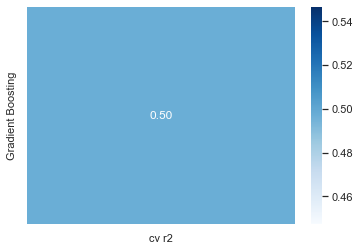

In [48]:
#sns.color_palette("Spectral", as_cmap=True)
sns.heatmap(resultats_final[['cv r2']], annot=True, fmt=".2f", cmap="Blues")

<AxesSubplot:>

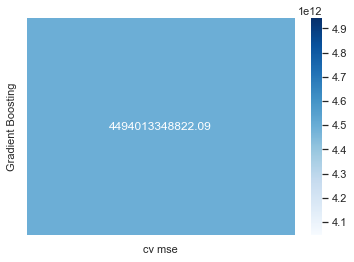

In [41]:
sns.heatmap(resultats_final[[ 'cv mse']], annot=True, fmt=".2f", cmap="Orange")

<AxesSubplot:>

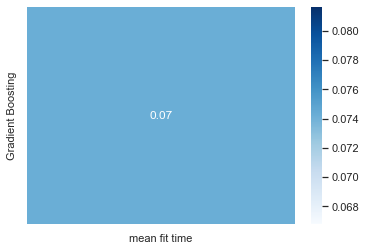

In [42]:
sns.heatmap(resultats_final[['mean fit time']], annot=True, fmt=".2f", cmap="Blues")

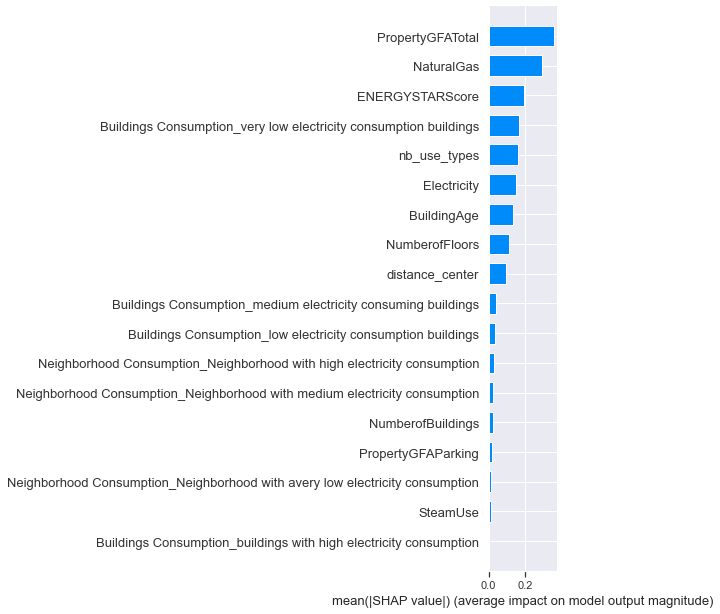

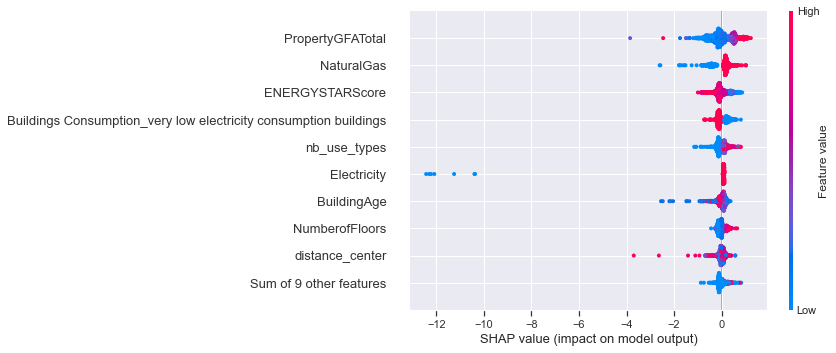

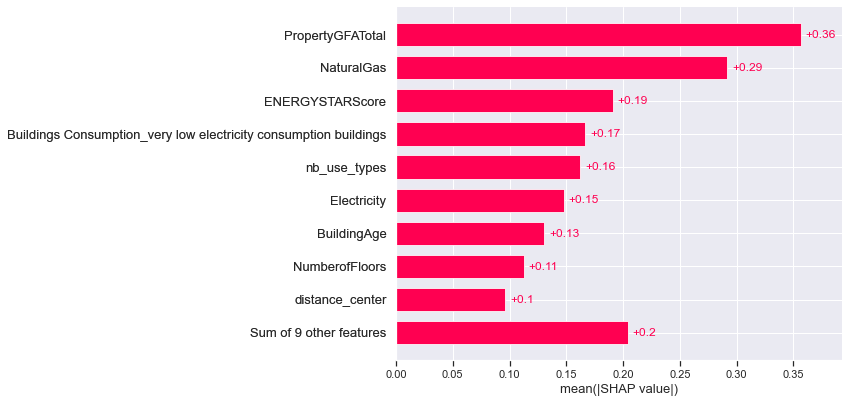

In [43]:
#colonne a transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#Calibrage
preprocessor.fit(X_train)

#Transformation
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


# Extraction des noms de variables
num_feature_names = preprocessor.transformers_[0][2]
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = num_feature_names + list(cat_feature_names)

# Calcul des valeurs SHAP pour chaque feature
explainer = shap.Explainer(grb_model[1]['transformer'].regressor_) #XGS
shap_values = explainer(X_train_transformed)

# Création d'un summary plot
shap.summary_plot(shap_values, X_train_transformed, plot_type="bar",feature_names=feature_names)

shap_values.feature_names = feature_names

shap.plots.beeswarm(shap_values)

# Création d'un bar plot
shap.plots.bar(shap_values)